# Measuring Engagement and Satisfaction in Online Mental Health Platform Conversations

## Data preprocessing

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import log10, floor
import math
import nltk

In [311]:
# Display long column text
pd.options.display.max_colwidth = 500

df = pd.read_csv("mentalhealthsupport_dyadic_convs_clean_emotion.csv")
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})

In [312]:
### --- CLEANING OUT MONOLOGUES FROM DATASET --- ###

# Group data by conversation id and calculate count of each conversation id
df_conv = df.groupby("conversation_id").count()
df_conv = df_conv.drop(columns=["subreddit", "post_title", "author", "text", "compound", "sentiment", "emotion_prediction"])
print("Number of conversations in subreddit: ", len(df_conv))

# Separate conversation id's with a single occurrence as monologues
df_mono = df_conv[df_conv["dialog_turn"] == 1]
print("Number of monologues in subreddit: ", len(df_mono))
df_mono_ids = df_mono.reset_index()
df_mono_ids = df_mono_ids["conversation_id"]

# Separate conversation id's with multiple occurrences as dialogues
df_dia = df_conv[df_conv["dialog_turn"] > 2]
print("Number of dialogues longer than 2 turns in subreddit: ", len(df_dia))
df_dia = df_dia.reset_index()
df_dia = df_dia.drop(columns=['dialog_turn'])

# Join dialogue conversation id's with original data such that only dialogues remain in the dataset
df = df.join(df_dia.set_index('conversation_id'), on='conversation_id', how="right") 

# TODO: possibly remove single interaction conversations too as we cannot determine satisfaction

### ---------------------------------------------- ###

Number of conversations in subreddit:  3551
Number of monologues in subreddit:  29
Number of dialogues longer than 2 turns in subreddit:  487


In [313]:
# Round numbers to a given number of significant figures (default = 2)
def round_sig(x, sig=2):
    if x != 0:
        return round(x, sig-int(floor(log10(abs(x))))-1)
    else:
        return

## Measuring the level of engagement

### Does the speaker respond back when the listener gives a response?

In [314]:
def extract_responses(conversation):
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item() 
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses)
    num_listener_responses = len(listener_responses)
    
    return speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

In [336]:
def calculate_engagement():
    speaker_listener_ratio = num_speaker_responses / num_listener_responses
    
    engagement = ""
    if len(conversation) == 2:
        engagement = "low engagement" # single interaction
    elif len(conversation) == 3:
        if speaker_listener_ratio == 2: 
            engagement = "low engagement" # repeated seeker interaction)
        else: #speaker_listener_ratio == 0.5: 
            engagement = "low engagement" # repeated peer supporter interaction
    elif len(conversation) == 4:
        if speaker_listener_ratio == 1:
            engagement = "high engagement" # TODO: ask if 4 is enough to classify as high engagement b/c Sharma et. al. classifies it as mutual discourse
        elif speaker_listener_ratio == 3 or speaker_listener_ratio == (1/3):
            engagement = "low engagement"
    elif len(conversation) > 4:
        if speaker_listener_ratio >= 0.7 and speaker_listener_ratio <= 1.35:
            engagement = "high engagement"
        elif speaker_listener_ratio <= 0.5 or speaker_listener_ratio >= 1.5:
            engagement = "low engagement"
        else:
            engagement = "moderate engagement"
        
    return round_sig(speaker_listener_ratio), engagement

### Does the listener ask any informative questions or give any suggestions? 

Unfortunately, the emotion predictions are very inaccurate. Normally, we could have given bonus points to questioning and/or suggesting listener responses. 

## Measuring the level of satisfaction

### Shift of sentiment in speaker responses (sentiment trend)

In [316]:
def plot_emotion_sentiment():   
    sns.set_theme(style="white")
    g = sns.relplot(x="dialog_turn", y="compound", hue="sentiment", style="emotion_prediction", palette="Set1",data=speaker_responses, s=200)
    g.fig.suptitle('Sentimental and Emotional Shift in Speaker Responses with Conversation Progression', fontsize=16)
    g.fig.subplots_adjust(top=0.9);

In [317]:
def calculate_satisfaction():
    satisfaction = ""

    f = np.polyfit(speaker_responses['dialog_turn'], speaker_responses['compound'], deg=1)
    slope = f[0]
    
    # If either the last speaker text is tagged with grateful & positive 
    # or if the last speaker text contains lexical details that express gratitude, add a bonus point to satisfaction.
    grateful_bonus = 0
    if check_grateful_positive()==True or check_lexical_details()==True:
        grateful_bonus = 0.4
        slope += grateful_bonus
        
    if len(conversation) == 2:
        satisfaction = "none"
    else:
        if slope >= 0.8: 
            satisfaction = "positive satisfaction"
        elif slope >= 0.4:
            satisfaction = "moderate satisfaction"
        elif slope < 0.4 and slope >= 0:
            satisfaction = "neutral satisfaction"
        elif slope < 0:
            satisfaction = "negative satisfaction"
            
    return round_sig(slope), satisfaction, grateful_bonus

In [318]:
# TODO: optimize these hyperparameters 
# TO ASK: should I train an ML model and assign hyperparameters using that? but then I would have to utilize the whole data

### Check if the last speaker turn has grateful emotion and has positive sentiment

In [319]:
# Return all emotions and the final emotion of the given responses
def get_emotion_prediction():
    emotions = speaker_responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [320]:
# Return all sentiments and the final sentiment of the given responses
def get_sentiment():
    sentiments = speaker_responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

In [321]:
# Check if the last speaker emotion is grateful and its sentiment is positive. If yes, return true. Otherwise, return false.
def check_grateful_positive():
    _, final_sentiment = get_sentiment()
    _, final_emotion = get_emotion_prediction()
    
    if final_sentiment == "positive" and final_emotion == "grateful":
        return True
    
    return False

### Check if the last speaker turn contains lexical details that express gratitude, e.g. "Thank you" or "It means a lot"

In [322]:
def check_lexical_details():
    # TO ASK: I couldn't find a gratitude lexicon. Will I create one myself or is there one that I don't know of?
    
    tokens = nltk.word_tokenize(speaker_responses["text"].iloc[-1].lower())
    
    if "thank" in tokens: # if we get a lexicon of gratitude I can check if any of those words are in tokens (can also use ngrams)
        return True
        
    return False

## Final classification

In [323]:
def classify_conversation(conversation):
    return str(calculate_engagement()[1] + ", " + calculate_satisfaction()[1])

## Testing the measures with examples

In [337]:
def test_examples(conversation_id):
    plot_emotion_sentiment()
    print("Conversation length: ", len(conversation))
    print("Speaker listener ratio: ", calculate_engagement()[0], " --> ", calculate_engagement()[1])
    print("Sentiment shift: ", calculate_satisfaction()[0], " with grateful bonus: ", calculate_satisfaction()[2], " --> ", calculate_satisfaction()[1])
    print("Classification summary: ", classify_conversation(conversation))

Enter conversation id:  110


Conversation length:  7
Speaker listener ratio:  1.3  -->  high engagement
Sentiment shift:  0.63  with grateful bonus:  0.4  -->  moderate satisfaction
Classification summary:  high engagement, moderate satisfaction


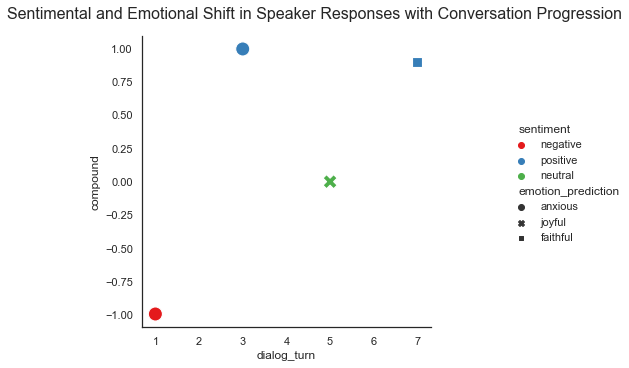

In [338]:
conversation_id = int(input("Enter conversation id: "))
conversation = df[df["conversation_id"] == conversation_id]
speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation)
test_examples(conversation_id)

In [339]:
conversation

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
254,110,MentalHealthSupport,Lonely at University,imkindastrange,1,"Long story short... Home is a bad place for me. Parents are verbally abusive, neglectful, and occasionally physically abusive (not enough that CPS would do anything about it though) and I encountered a lot of physical, sexual, and verbal abuse from people outside of the home so I have pretty bad trauma. I started taking dance last year and for the first time, made friends. Like, REAL ones. For the first time. And my dance teacher gave me all these amazing opportunities! I even got to meet B...",-0.9929,negative,anxious
255,110,MentalHealthSupport,Lonely at University,chrisfs,2,"Wow, that's a lot of stuff and I wish I knew exactly what to say, but I don't exactly know. I want you to know that you will get through this. I have gone through really hard periods of anxiety and depression and I have gotten through them. That there will be better days and that you know there are cool people out there. They exist and the ones you have already met are not the only ones. In University, you could find other cool people. Are their interest groups or clubs of things that int...",0.9891,positive,anxious
256,110,MentalHealthSupport,Lonely at University,imkindastrange,3,"That’s okay, I don’t really expect people to know what to say. It’s a lot to take in. If I told you the whole of it, you would be so shocked, lol. I understand that professionals are the only people I should expect to fully know how to handle my situation. And thanks, man. It honestly doesn’t feel like that anymore. I can’t really explain why. My mind is starting to give up, and I’m actively combatting that. Life has been WAY WAY WAY worse than it is now. Honestly, aside from the loneliness...",0.9959,positive,anxious
257,110,MentalHealthSupport,Lonely at University,chrisfs,4,"I am glad you are feeling at least a little better. For more therapy, check into getting health insurance through www.healthcare.gov. Some plans can be pretty cheap because part of how much you pay is based on your income and if you don't have much or any that could work out. Look at the deductibles though, which are how much you have to pay before the insurance pays for stuff. It can be anything from $0 to a few thousand, The deadline for getting insurance that starts on Jan 1 is Dec 15, ...",0.8180,positive,anxious
258,110,MentalHealthSupport,Lonely at University,imkindastrange,5,"At this point, I’m covered by my family as I am 18. Are you saying I should switch over to get my own now?",0.0000,neutral,joyful
259,110,MentalHealthSupport,Lonely at University,chrisfs,6,"No, I was just saying that you should get some kind of coverage which would help you afford therapy visits beyond the ones given by your school if you wanted them. I didn't know you had coverage through your family. I forgot about that.",0.4019,positive,anxious
260,110,MentalHealthSupport,Lonely at University,imkindastrange,7,Gotcha. Thank you for all the help! It is thoroughly appreciated. I had a better day today.,0.8997,positive,faithful


## Emotion prediction is not accurate at all...

In [340]:
conversation_bad_emotion_prediction_example = df[df["conversation_id"] == 1754]
conversation_bad_emotion_prediction_example

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
4191,1754,MentalHealthSupport,Another Cry for Help,Neko_Styx,1,Hello everyone. I'm a F(19) - and I've been struggling with what I call attack-like visions of torture and violence for over a year now. I've had bad intrusive thoughts before - and since I've been in therapy for close to 2 years now I have actually gotten pretty good at dealing with them. But a year ago it went from only those thoughts to actual Attacks. I'll describe the latest one; It was around 11pm - I was on the phone with my Fianceé when I suddenly felt like my entire room was sl...,-0.9868,negative,anxious
4192,1754,MentalHealthSupport,Another Cry for Help,TheBassClarinetBoy,2,Hey friend. Have you had any past traumas?,0.0000,neutral,sympathizing
4193,1754,MentalHealthSupport,Another Cry for Help,Neko_Styx,3,"Well - Yes, I grew up with a very hot n cold manipulative and borderline sociopathic father. I was molested by my brothers best friend when I was 6 years old. I was bullied pretty much always from grade 1 through 10. I have slight PTSD from my Parents fighting (get shaky and stuff when people raise their voices) That's about it I think - though my childhood memories are hard to remember in their entirety - but those are the things that stuck vividly.",-0.0516,negative,hopeful
4194,1754,MentalHealthSupport,Another Cry for Help,TheBassClarinetBoy,4,Could these attacks be PTSD flashbacks?,-0.4404,negative,sentimental
4195,1754,MentalHealthSupport,Another Cry for Help,Neko_Styx,5,"As mentioned - all the people are perfect strangers , getting torn apart or tortured in diverse locations and without any link. I've never been physically hurt by anyone and haven't ever witnessed a crime at all , much less of that capacity.",-0.3867,negative,embarrassed
4196,1754,MentalHealthSupport,Another Cry for Help,TheBassClarinetBoy,6,Is it possible you’re having psychotic episodes?,0.0000,neutral,anticipating
4197,1754,MentalHealthSupport,Another Cry for Help,Neko_Styx,7,I said in another comment that ai brought it up with my Therapist - she said that Psychotic episodes usually take a lot longer to get through then a maximum of 30 minutes as I have experienced.,0.0000,neutral,faithful
4198,1754,MentalHealthSupport,Another Cry for Help,TheBassClarinetBoy,8,Has your therapist ever mention schizophrenia?,0.0000,neutral,guilty
4199,1754,MentalHealthSupport,Another Cry for Help,Neko_Styx,9,"Schizophrenia is mostly delusional - though there are hallucinations too - I asked and researched , any disorder that falls under that umbrella has at least one month of consistent psychotic symptoms.",-0.4019,negative,lonely
4200,1754,MentalHealthSupport,Another Cry for Help,TheBassClarinetBoy,10,Have there been any additional stressors since you’ve started to have these hallucinations?,-0.4767,negative,sentimental


When we check the emotion predictions, we see that most of them are very inaccurate. The sentiment tags are more accurate, but sometimes they fail too.

In [341]:
df[df["emotion_prediction"]=="questioning"]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
799,342,MentalHealthSupport,Mental Health in the Black Community,yadadameannn,4,thanks man. We just got everything fixed. We were working on coding this weekend. Everything is fine now.,0.5719,positive,questioning
1361,578,MentalHealthSupport,Let Me Introduce Myself,antwerpbanana,2,"Hi Caty, thank you for sharing your story. I hope we can be of help to you here.",0.8720,positive,questioning


In [342]:
print(df[(df["conversation_id"]==342) & (df["dialog_turn"]==4)]["text"])
print(df[(df["conversation_id"]==455) & (df["dialog_turn"]==2)]["text"])
print(df[(df["conversation_id"]==578) & (df["dialog_turn"]==2)]["text"])
print(df[(df["conversation_id"]==1761) & (df["dialog_turn"]==2)]["text"])
print(df[(df["conversation_id"]==2414) & (df["dialog_turn"]==2)]["text"])

799    thanks man. We just got everything fixed. We were working on coding this weekend. Everything is fine now. 
Name: text, dtype: object
Series([], Name: text, dtype: object)
1361    Hi Caty, thank you for sharing your story. I hope we can be of help to you here.
Name: text, dtype: object
Series([], Name: text, dtype: object)
Series([], Name: text, dtype: object)


The questioning tags are not accurate either. Only one of the statements that are tagged with the questioning tag are actually questioning.

In [343]:
df[df["emotion_prediction"]=="suggesting"]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
